
### ==========================================================================================
# PART 4: FINAL MODEL SELECTION
### ==========================================================================================

In [1]:
import os
import re
import seaborn as sn
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas_ml import ConfusionMatrix
from keras.preprocessing import image as im
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# project folder
path_project = 'E:/DeepLearning/breast_cancer/IDC_regular_ps50_idx5/'

# set test folder
dir_test = os.path.join(path_project, '_test_single')

# dinamically read folders as categories, excluding files (i.e. contains ".") and train, validate and test folders when present
categories = [folder for folder in os.listdir(path_project) if not re.search(r'[\.|_|model]', folder, re.I)]

print('CATEGORIES:', categories)

CATEGORIES: ['0', '1']


### Functions for performance metrics and image display

In [3]:
def model_performance(model_name):
    model_test = load_model(os.path.join(path_project, 'MODELS', model_name))
    
    gen_test.reset()
    predictions = model_test.predict_generator(gen_test, verbose=1)
        
    # option 1: get img class from filenames in generator (both options match, but this is more reliable)
    y_true = [int(x.split('class')[1].split('.')[0]) for x in gen_test.filenames]  
    
    # option 2: get img class from filenames in folders
    #y_true = [int(file.split('_class')[1].split('.')[0]) for file in os.listdir(path_project + '_test_single' + '/test_folder')]
    
    # get predictions
    y_pred = [int(np.rint(pred[0])) for pred in predictions]
    
    # confusion matrix
    cm = ConfusionMatrix(y_true, y_pred)
    
    # model id
    model_id = re.sub('[^0-9]', '', model_name.split('.')[0])
    
    # performance metrics
    accuracy = cm.stats()['ACC']  # correct predictions
    precision = cm.stats()['PPV']  # positive predictive value
    sensitivity = cm.stats()['TPR']  # true positive rate, recall
    specificity = cm.stats()['TNR']  # true negative rate
    f1_score = cm.stats()['F1_score']  # weighted average of precision and recall (TPR)
    
    return [model_id, cm, accuracy, precision, sensitivity, specificity, f1_score]


def display_imgs(df, n):
    fig = plt.figure(figsize=(n, n))            
    for k in range(n):    
        fig.add_subplot(1, n, k+1)
        plt.imshow(im.load_img(os.path.join(dir_test, 'test_folder', df.loc[k, 'file'])))
        plt.axis('off')      

### Select top performing models (based on training validation accuracy)

In [4]:
# read generations file
df_generations = pd.read_csv(os.path.join(path_project, 'generations.csv')).fillna('')

# select only alive individuals
df_select = df_generations[df_generations.alive]

df_select = df_select.sort_values('val_acc', ascending=False)
df_select

,batch_size,steps_per_epoch,validation_steps,epochs,learning_rate,train_loss,train_acc,val_loss,val_acc,time,gen,alive
653,100,190,10,90,0.0001,0.317655,0.865789,0.292571,0.894000,0:11:41,1,True
1240,160,140,10,80,0.0010,0.309508,0.870714,0.298903,0.886250,0:12:35,3,True
1178,80,190,30,50,0.0010,0.333464,0.858750,0.292957,0.884583,0:05:13,2,True
1278,200,130,10,90,0.0010,0.302942,0.873192,0.296192,0.882000,0:17:44,3,True
1129,200,200,20,70,0.0001,0.311461,0.867375,0.295427,0.881832,0:29:50,2,True
1107,80,160,10,80,0.0010,0.321133,0.866250,0.336637,0.881250,0:10:42,2,True
1038,100,200,10,90,0.0010,0.306632,0.870800,0.317246,0.881000,0:14:31,2,True
1250,200,190,30,100,0.0010,0.284835,0.881026,0.298489,0.878500,0:28:42,3,True
1267,200,150,20,60,0.0010,0.310335,0.870633,0.298475,0.878250,0:13:40,3,True
1039,100,190,10,50,0.0001,0.344512,0.852526,0.317177,0.878000,0:07:40,2,True


### Calculate model performance metrics

In [5]:
# generator for imagesin test set
datagen_test = ImageDataGenerator(rescale=1./255)
gen_test = datagen_test.flow_from_directory(dir_test, batch_size=1, target_size=(50,50), shuffle=False, class_mode=None)

Found 27752 images belonging to 1 classes.


In [6]:
# dataframe for kpi's
df_kpi = pd.DataFrame()

# loop through the surviving models
for i, row in enumerate(df_select.itertuples()):
    model_name = f'model_breast_cancer_{str(row.Index)}.h5'
    print('Calculating performance metrics:', model_name, '(' + str(i+1), 'of', str(len(df_select)) + ')') 
    
    m = model_performance(model_name)
    
    df_kpi = df_kpi.append([m], ignore_index=True)

    print('\n')
    
print('Calculations completed')    
df_kpi.columns = ['model_name', 'cm', 'accuracy', 'precision', 'sensitivity', 'specificity', 'f1_score']

Calculating performance metrics: model_breast_cancer_653.h5 (1 of 17)
27752/27752 [==============================] - 32s 1ms/step


Calculating performance metrics: model_breast_cancer_1240.h5 (2 of 17)
27752/27752 [==============================] - 33s 1ms/step


Calculating performance metrics: model_breast_cancer_1178.h5 (3 of 17)
27752/27752 [==============================] - 34s 1ms/step


Calculating performance metrics: model_breast_cancer_1278.h5 (4 of 17)
27752/27752 [==============================] - 33s 1ms/step


Calculating performance metrics: model_breast_cancer_1129.h5 (5 of 17)
27752/27752 [==============================] - 34s 1ms/step


Calculating performance metrics: model_breast_cancer_1107.h5 (6 of 17)
27752/27752 [==============================] - 34s 1ms/step


Calculating performance metrics: model_breast_cancer_1038.h5 (7 of 17)
27752/27752 [==============================] - 35s 1ms/step


Calculating performance metrics: model_breast_cancer_1250.h5 (8 of 17)

### Select top performing model (based on highest F1 score)

In [7]:
df_kpi_f1_score = df_kpi.sort_values('f1_score', ascending=False).reset_index(drop=True)
df_kpi_f1_score

,model_name,cm,accuracy,precision,sensitivity,specificity,f1_score
0,1250,Predicted False True __all__\nActual ...,0.876766,0.790413,0.770148,0.919036,0.780149
1,1312,Predicted False True __all__\nActual ...,0.870712,0.761678,0.792613,0.901676,0.776838
2,1278,Predicted False True __all__\nActual ...,0.874423,0.791302,0.757457,0.920797,0.774009
3,1029,Predicted False True __all__\nActual ...,0.874892,0.796528,0.751237,0.923917,0.773220
4,1313,Predicted False True __all__\nActual ...,0.873847,0.795971,0.747176,0.924068,0.770802
5,1306,Predicted False True __all__\nActual ...,0.875937,0.825793,0.713542,0.940321,0.765575
6,1129,Predicted False True __all__\nActual ...,0.868586,0.778348,0.750984,0.915212,0.764421
7,653,Predicted False True __all__\nActual ...,0.864839,0.756908,0.771798,0.901726,0.764281
8,1038,Predicted False True __all__\nActual ...,0.870424,0.792195,0.736896,0.923363,0.763546
9,1300,Predicted False True __all__\nActual ...,0.869523,0.786927,0.741084,0.920445,0.763318


In [8]:
# Confusion matrix
cm = df_kpi_f1_score.loc[0, 'cm']
cm

Predicted  False  True  __all__
Actual                         
False      18264  1609    19873
True        1811  6068     7879
__all__    20075  7677    27752

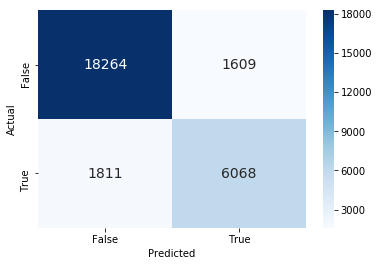

In [9]:
heatmap = cm.plot(backend='seaborn', annot=True, cmap='Blues', cbar=True, fmt='g', annot_kws={"size": 14})

### Select top performing model (based on highest sensitivity or recall)

In [10]:
df_kpi_sensitivity = df_kpi.sort_values('sensitivity', ascending=False).reset_index(drop=True)
df_kpi_sensitivity

,model_name,cm,accuracy,precision,sensitivity,specificity,f1_score
0,1312,Predicted False True __all__\nActual ...,0.870712,0.761678,0.792613,0.901676,0.776838
1,1107,Predicted False True __all__\nActual ...,0.858605,0.736515,0.781571,0.889146,0.758374
2,653,Predicted False True __all__\nActual ...,0.864839,0.756908,0.771798,0.901726,0.764281
3,1250,Predicted False True __all__\nActual ...,0.876766,0.790413,0.770148,0.919036,0.780149
4,1278,Predicted False True __all__\nActual ...,0.874423,0.791302,0.757457,0.920797,0.774009
5,1029,Predicted False True __all__\nActual ...,0.874892,0.796528,0.751237,0.923917,0.773220
6,1129,Predicted False True __all__\nActual ...,0.868586,0.778348,0.750984,0.915212,0.764421
7,1313,Predicted False True __all__\nActual ...,0.873847,0.795971,0.747176,0.924068,0.770802
8,1300,Predicted False True __all__\nActual ...,0.869523,0.786927,0.741084,0.920445,0.763318
9,1038,Predicted False True __all__\nActual ...,0.870424,0.792195,0.736896,0.923363,0.763546


In [11]:
# Confusion matrix
cm = df_kpi_sensitivity.loc[0, 'cm']
cm

Predicted  False  True  __all__
Actual                         
False      17919  1954    19873
True        1634  6245     7879
__all__    19553  8199    27752

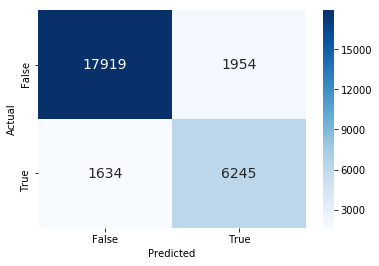

In [12]:
heatmap = cm.plot(backend='seaborn', annot=True, cmap='Blues', cbar=True, fmt='g', annot_kws={"size": 14})

### Predict images in test set (sensitivity/recall chosen as the desired metric)

In [13]:
# Create dataframe to hold predictions on test set
df_test = pd.DataFrame()

for folder in os.listdir(dir_test):
    for file in os.listdir(os.path.join(dir_test, folder)):
        if re.search(r'\.png$', file):
            df_test = df_test.append(pd.DataFrame({'file':[file]}), ignore_index=True)    

# extract true class embedded in filename
df_test['y_true'] = df_test.file.apply(lambda x: x.split('class')[1].split('.')[0])

df_test.head()

,file,y_true
0,10253_idx5_x1001_y1501_class0.png,0
1,10253_idx5_x1051_y151_class0.png,0
2,10253_idx5_x1151_y551_class0.png,0
3,10253_idx5_x1151_y701_class0.png,0
4,10253_idx5_x1201_y1351_class0.png,0


In [14]:
# load saved model
model_name = f"model_breast_cancer_{str(df_kpi_sensitivity.loc[0, 'model_name'])}.h5"
model_test = load_model(os.path.join(path_project, 'MODELS', model_name))

# predict images
gen_test.reset()
predictions = model_test.predict_generator(gen_test, verbose=1)

27752/27752 [==============================] - 39s 1ms/step


In [16]:
y_pred = [str(round(x[0])) for x in predictions.tolist()]
y_pred_prob = [x[0] for x in predictions.tolist()]

df_test = pd.concat([df_test, pd.Series(y_pred), pd.Series(y_pred_prob)], ignore_index=True, axis=1)
df_test.columns = ['file', 'y_true', 'y_pred', 'y_pred_prob']

In [17]:
df_test.head(10)

,file,y_true,y_pred,y_pred_prob
0,10253_idx5_x1001_y1501_class0.png,0,0,0.024449
1,10253_idx5_x1051_y151_class0.png,0,0,0.008627
2,10253_idx5_x1151_y551_class0.png,0,0,0.316427
3,10253_idx5_x1151_y701_class0.png,0,1,0.870326
4,10253_idx5_x1201_y1351_class0.png,0,0,0.187531
5,10253_idx5_x1201_y401_class0.png,0,0,0.041283
6,10253_idx5_x1201_y451_class0.png,0,1,0.656394
7,10253_idx5_x1251_y1251_class0.png,0,0,0.170695
8,10253_idx5_x1251_y901_class0.png,0,1,0.623490
9,10253_idx5_x1301_y1101_class0.png,0,1,0.760330


### View example predictions

In [18]:
df_TP = df_test[(df_test.y_true == '1') & (df_test.y_pred == '1')].reset_index(drop=True)  # true positives
df_TN = df_test[(df_test.y_true == '0') & (df_test.y_pred == '0')].reset_index(drop=True)  # true negatives
df_FP = df_test[(df_test.y_true == '0') & (df_test.y_pred == '1')].reset_index(drop=True)  # false positives
df_FN = df_test[(df_test.y_true == '1') & (df_test.y_pred == '0')].reset_index(drop=True)  # false negatives

#### True Positives

6245


,file,y_true,y_pred,y_pred_prob
0,10253_idx5_x601_y751_class1.png,1,1,0.649673
1,10253_idx5_x751_y451_class1.png,1,1,0.888613
2,10253_idx5_x751_y701_class1.png,1,1,0.706819
3,10253_idx5_x751_y751_class1.png,1,1,0.524811
4,10254_idx5_x1651_y1051_class1.png,1,1,0.906722


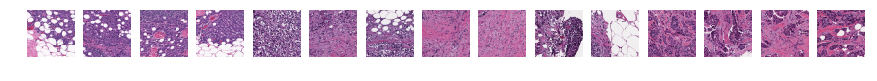

In [19]:
display_imgs(df_TP, 15)
print(len(df_TP))
df_TP.head()

#### False Positives

1954


,file,y_true,y_pred,y_pred_prob
0,10253_idx5_x1151_y701_class0.png,0,1,0.870326
1,10253_idx5_x1201_y451_class0.png,0,1,0.656394
2,10253_idx5_x1251_y901_class0.png,0,1,0.623490
3,10253_idx5_x1301_y1101_class0.png,0,1,0.760330
4,10253_idx5_x1451_y1001_class0.png,0,1,0.759450


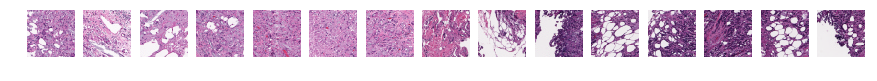

In [20]:
display_imgs(df_FP, 15)
print(len(df_FP))
df_FP.head()

#### True Negatives

17919


,file,y_true,y_pred,y_pred_prob
0,10253_idx5_x1001_y1501_class0.png,0,0,0.024449
1,10253_idx5_x1051_y151_class0.png,0,0,0.008627
2,10253_idx5_x1151_y551_class0.png,0,0,0.316427
3,10253_idx5_x1201_y1351_class0.png,0,0,0.187531
4,10253_idx5_x1201_y401_class0.png,0,0,0.041283


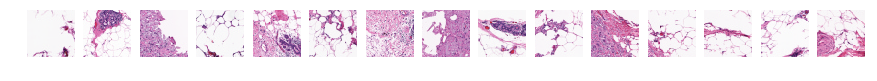

In [21]:
display_imgs(df_TN, 15)
print(len(df_TN))
df_TN.head()

#### False Negatives

1634


,file,y_true,y_pred,y_pred_prob
0,10255_idx5_x151_y1051_class1.png,1,0,0.234125
1,10256_idx5_x1601_y1101_class1.png,1,0,0.217857
2,10256_idx5_x1851_y901_class1.png,1,0,0.443880
3,10256_idx5_x1951_y1401_class1.png,1,0,0.324580
4,10256_idx5_x2151_y951_class1.png,1,0,0.479504


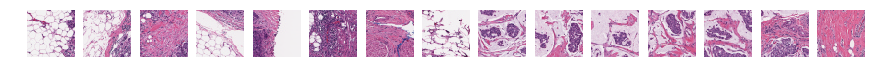

In [22]:
display_imgs(df_FN, 15)
print(len(df_FN))
df_FN.head()